<a href="https://colab.research.google.com/github/chrisamz/142-Final-Project/blob/main/PHYS142_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://colab.research.google.com/drive/1u4i8yjjlho_YPSw_PImcqVMbVDoy22Fm?usp=sharing

updates

8pm sat: 

i think rho and mcmc function are drafted for the most part, just unsure about the x_next calculation, and what $\Delta$ (`delta`) and $ɛ$ (`epsilon`) are?

```x_next = x_curr+(choice(path[i]) -0.5)*delta``` (?)
 - We are looking for a new point within a square of length $\Delta$, which is done by sampling uniformly in $[-\Delta/2, \Delta/2]$ for each axis. Python code would probably be something like `(np.random.rand(numdims) - 0.5)*delta`
 (see [numpy doc](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html))

10 pm sun:

in this file, replaced anastasia's mcmc code with kentaro's mmc code and drafted the next steps (unfinished)

# PHYS 142 Final Project (Prompt #2)
# Spr '22
## Group members:
### Christian Amezcua, Kentaro Hanson, Anastasia Ordonez

*Consider the double-well oscillator for quantum mechanical electron*

### (a)
*Evaluate the ground state energy $E_0$ from the Metropolis Monte Carlo path integral approximation for sufficiently large $\tau$ so that $E_0$ dominates*

In [ ]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs # python adaptation of ARPACK
from scipy.sparse import spdiags
from random import randint
from random import choice
from random import random

#### parameters (taken from previous assignments)

In [ ]:
k = 2
alpha = 0.4

m = 1
hbar = 1
omega = 1
xmin = 1 / np.sqrt(alpha) # absolute value of potential well minima
#barrier = 1 / alpha # potential barrier height (unsure if necessary)

#sampling parameters
n_d = 600 # spatial resolution (num of points sampled)
x_0 = -4 # lower spatial bound
x_d = 4 # higher spatial bound
delta_x = (x_d - x_0) / n_d # spatial step size
x_size = n_d + 1 # total spatial steps
x = np.linspace(x_0, x_d, x_size) # (n_d + 1) vector of position points

N = 1000
T0 = 2*np.pi
delta_t = T0 / 600 # epsilon / time resolution (more precise, also called epsilon in notes)
t_size = 128 # total time steps
tau = N*delta_t # time resolution (less precise, similar to T0/16 time steps from hw 1)
t = np.linspace(0,t_size * tau,t_size)

In [ ]:
print(delta_t)
print(tau)

0.010471975511965976
10.471975511965976


In [ ]:
# input vector of wave function/probability amplitude to normalize
def normalize(psi):
  #manually sum up (inner prod) and multiply by delta_x
  #(recall riemann sum)
  check = np.zeros(len(psi),dtype = np.complex64)
  for i in range(len(psi)):
    check[i] = np.conjugate(psi[i]) * psi[i] * delta_x
  Asquared = sum(check)  #if equal to 1, is normalized
  A = 1 / np.sqrt(Asquared) # normalization factor
  normalized_psi = A * psi
  return normalized_psi

# for graphing probability density of wavefunction
#def graph_prob_density(psi):
#  return np.real(np.conjugate(psi) * psi)

# double well potential
def double_well_potential(x):
  #ans = alpha * (x - xmin)**2 * (x + xmin)**2 # equivalent expression
  ans = -k * x**2 + alpha * x**4 + (1 / alpha)
  return ans

#constructing potential vector
vx = np.zeros(x_size)
for i in range(x_size):
  vx[i] = double_well_potential(x[i])

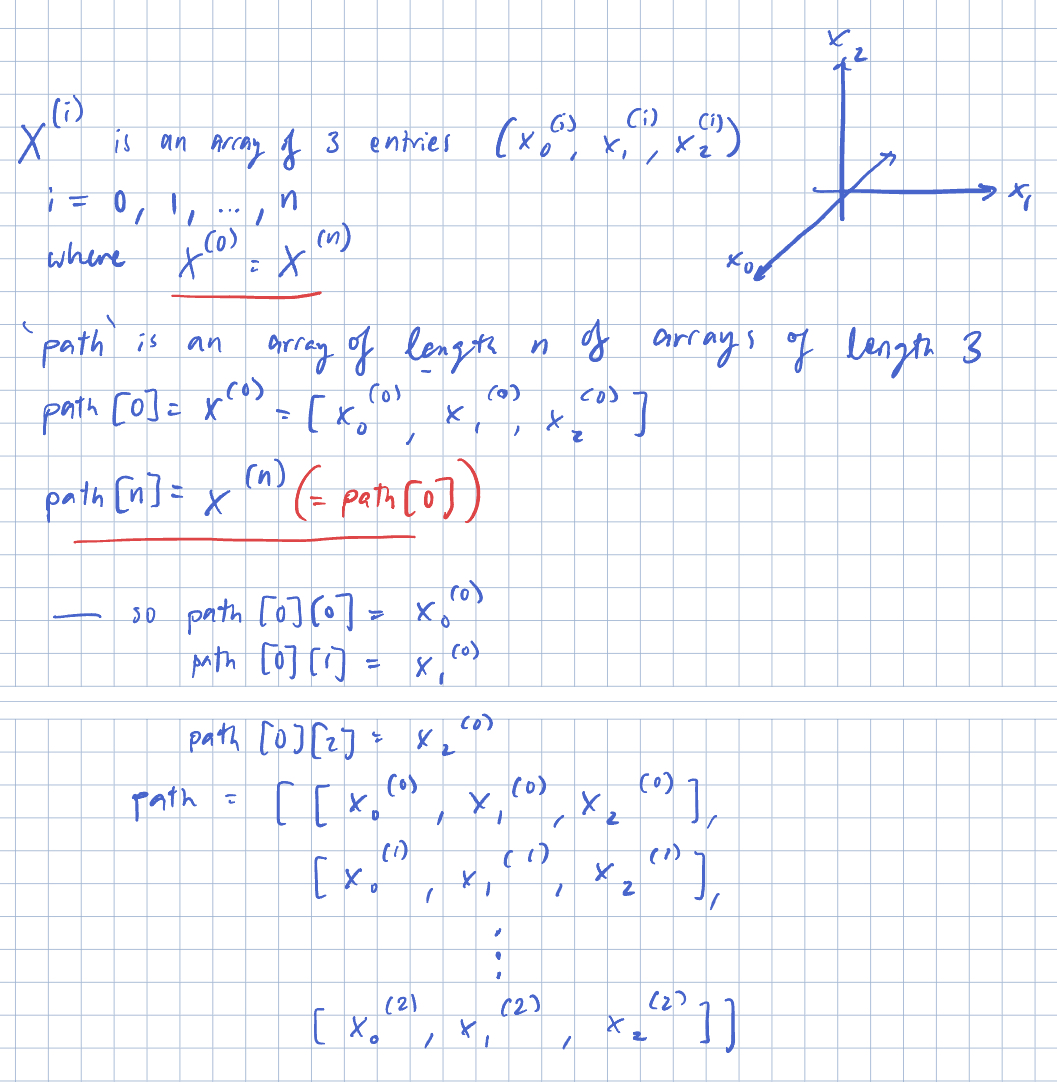

In [ ]:
num_configs = 25 # length of electron path aka number of configurations/points in path
n = 3 # dimension of configuration (here, 3d as shown above)

#initialize path matrix/array of arrays representing the coordinates
#will update in MCMC code as we continuously choose next position
path = np.zeros((num_configs, n))

#choose starting point (random)
#from parameters: x_0 = -4 and x_d = 4
path[0] = [randint(x_0,x_d) for i in range(n)]
path[num_configs - 1] = path[0] # initial position = final position of electron
print("initial and final position of electron: ",path[0])

initial and final position of electron:  [ 0. -2.  2.]


In [ ]:
len(path)==num_configs

True

#### define probability density expression $\rho_\tau(x)$ and mcmc function to start choosing points

In [ ]:
import numpy as np
from numpy.random import rand

def mmc(p,x0,delta=1):
    """Samples the next point from p using Metropolis Monte Carlo.

    - p         a function that takes a vector and returns some value
                proportional to probability distribution to sample.

    - x0        the prior point. This must be the same size as what p takes.

    - delta     (optional) the length of the hypercube to sample from as in
                the metropolis update. (default: 1)
    """
    #metropolis update
    if hasattr(x0,"__len__"): #has len() attrib, assume it is a vector
        x1 = np.array(x0) + (rand(len(x0)) - 0.5)*delta
    else: #has no len(), assume it is a single value
        x1 = x0 + (rand() - 0.5)*delta
    a = rand() # acceptance parameter

    return x1 if a < p(x1)/p(x0) else x0

In [ ]:
epsilon = delta_t
#helper method to mcmc
#calculate probability density for each configuration/coordinate in choosing process
def rho(coord):
  #kinetic energy
  kesum = [(coord[i] - coord[i-1])**2 for i in range(1,len(coord))]
  kesum.append( (coord[ len(coord)-1 ] - coord[0])**2 ) #closed ring (? referring to lab session may 26)
  ke = m /(2*hbar*epsilon) * sum(kesum)

  #potential energy
  #`vvariable` replaces `x` in the potential energy formula for
  # `1/2 * (x[i-1] + x[i])`
  vvariable = [1/2 * (coord[i-1] + coord[i]) for i in range(1,len(coord))]
  vvariable.append(1/2 * (coord[ len(coord) - 1 ] + coord[0]) ) #closed ring
  vsum = [-k*vvariable[i]**2 + alpha*vvariable[i]**4 + (1/alpha) for i in range(len(vvariable))]
  v = epsilon / hbar * sum(vsum)

  #E = K + V
  etotal = np.exp(ke +v)

  rho = np.exp(-etotal) #rho ~ exp(-E)
  return rho

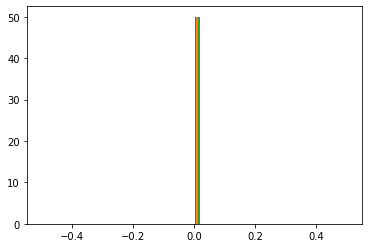

In [ ]:
num_samples = 25 # length of electron path aka number of configurations/points in path
n = 3 # dimension of configuration (here, 3d as shown above)
delta = delta_x

path = np.zeros((num_configs, n))
path[0] = [0 for i in range(n)] #initialize first point to origin

#populate remaining part of array
for i in range(1, num_samples):
  for dim in range(n): # runs mmc for each dimension before moving on
    mmc(rho,path[i-1])

plt.hist(path,bins=50,density=True) #uhhhhh idk what went wrong

#true distribution
#plt.plot(np.linspace(-3,3,100),np.exp(-np.linspace(-3,3,100)**2/2) / (np.sqrt(2*np.pi)))
plt.show()

### (b)
*Plot the ground state probability distribution*

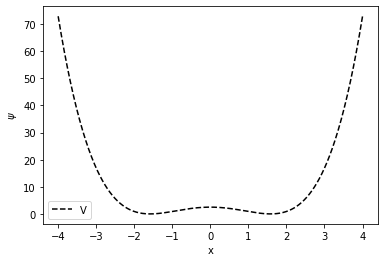

In [ ]:
plt.plot(x,vx,'k--',label="V")
plt.xlabel("x")
plt.ylabel(r"$\psi$")
plt.legend()
plt.show()

### (c)
*Can you calculate the average energy $<E>$ of the electron from the same simulation code when $\tau$ is much lower than in (a)*

### (d)
*Evaluate from the MC code (follow the hint) the probabilty distribution $\rho(x) = Σ \vert \psi_n(x)\vert^2 * p_n$ toward the $\tau → ∞$*